<a href="https://colab.research.google.com/github/Talha-shariff/Braintumor_detection/blob/main/btd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from tensorflow.keras.models import load_model


%matplotlib inline

In [ ]:
def crop_brain_contour(image, plot=False):

    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

In [ ]:
from abc import update_abstractmethods
from google.colab import files
uploaded = files.upload()




Saving Y1.jpg to Y1.jpg
Saving Y2.jpg to Y2.jpg
Saving Y3.jpg to Y3.jpg
Saving Y4.jpg to Y4.jpg
Saving Y6.jpg to Y6.jpg


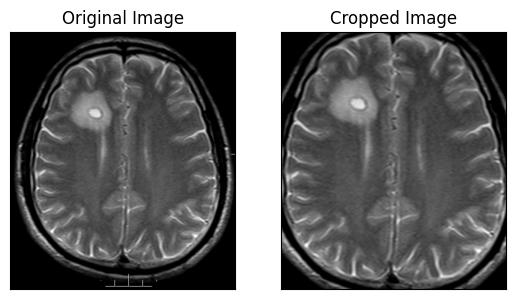

In [ ]:
ex_img = cv2.imread('Y3.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

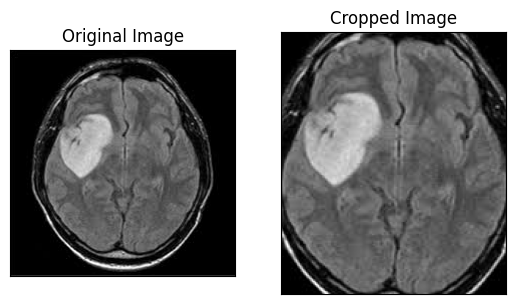

In [ ]:
ex_img = cv2.imread('Y4.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [ ]:
import cv2
import numpy as np
import os
from sklearn.utils import shuffle
from os import listdir

def load_data(dir_list, image_size):
    """
    Read images, resize, and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
        image_size: tuple (image_width, image_height) for resizing.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    # Initialize lists to hold image data and corresponding labels
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # Construct full path using os.path.join for compatibility across platforms
            file_path = os.path.join(directory, filename)

            # Load the image
            image = cv2.imread(file_path)
            if image is None:
                continue  # If the image is not read properly, skip it

            # Crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)

            # Resize the image to the target size
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # Normalize pixel values to be between 0 and 1
            image = image / 255.0

            # Append the image to X
            X.append(image)

            # Assign label: 1 if in 'yes' folder, 0 if in 'no' folder
            label = 1 if directory.endswith('yes') else 0
            y.append([label])

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Check if the path exists in the Google Drive
augmented_yes_path = '/content/drive/MyDrive/augmented data/yes'
augmented_no_path = '/content/drive/MyDrive/augmented data/no'

print("Yes folder exists:", os.path.exists(augmented_yes_path))
print("No folder exists:", os.path.exists(augmented_no_path))


Yes folder exists: True
No folder exists: True


X shape: (2065, 64, 64, 3)
y shape: (2065,)


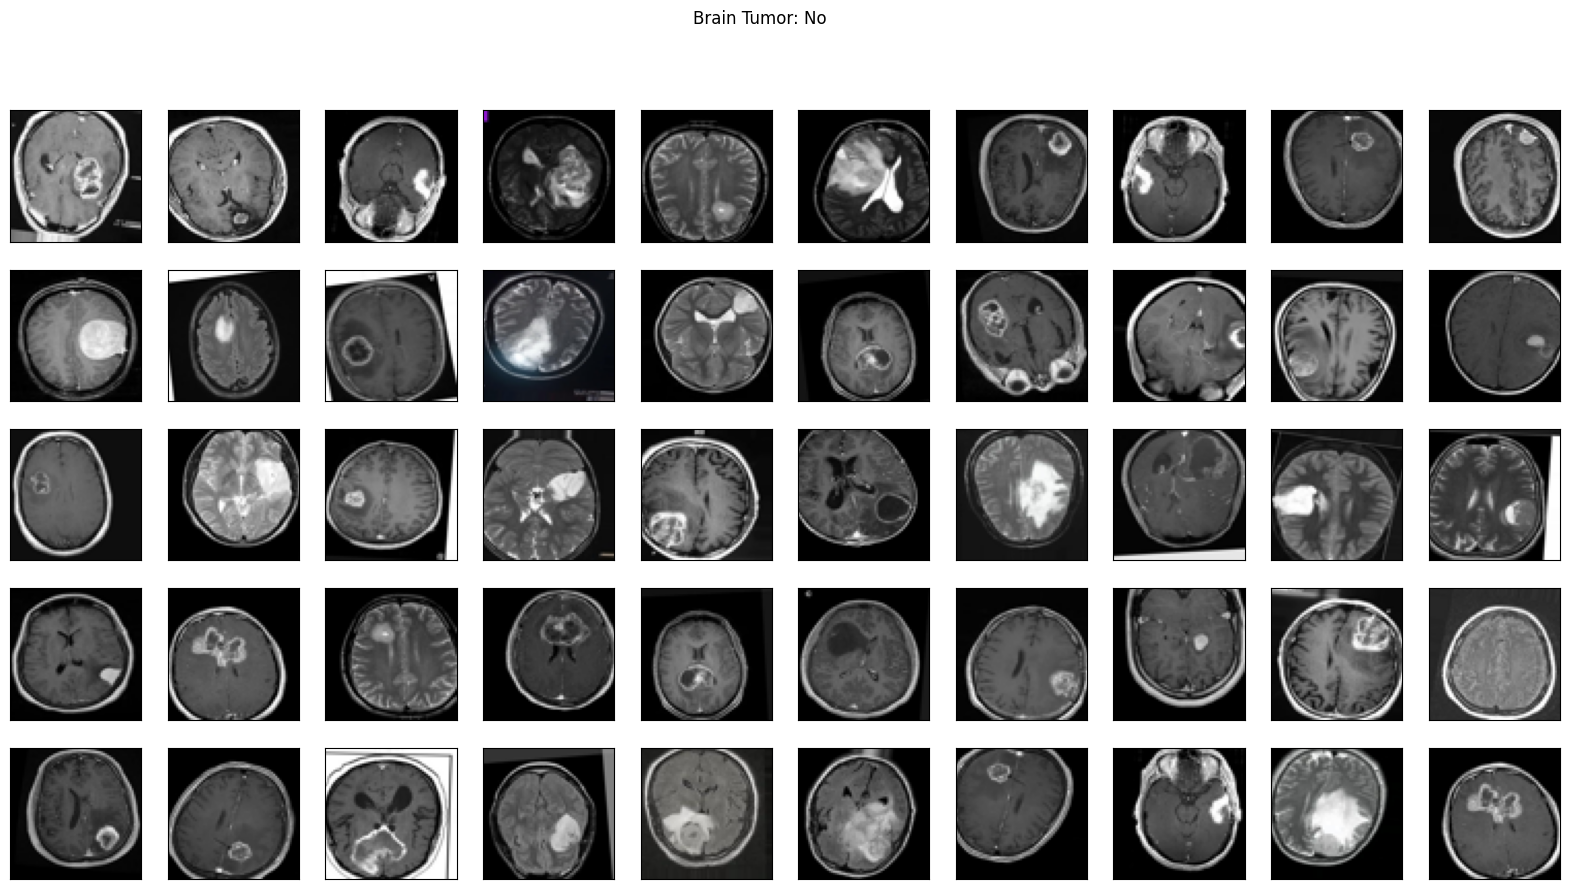

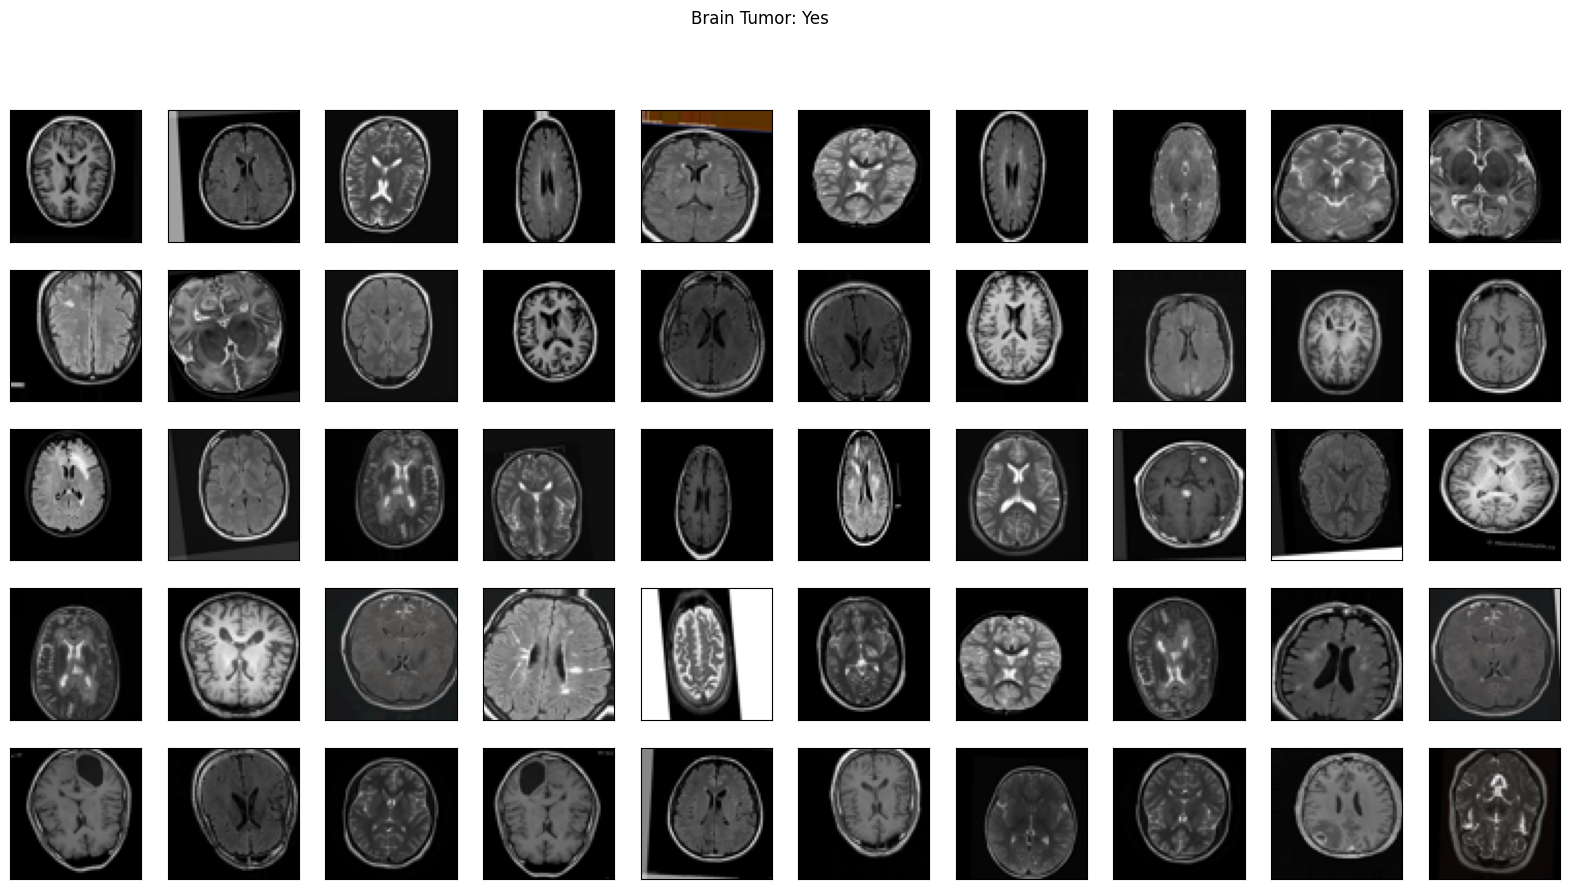

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Step 1: Define the load_data function
def load_data(directories, target_size):
    """
    Loads images from given directories and resizes them to the target size.
    Arguments:
        directories: A list of directories containing images for each class.
        target_size: A tuple (width, height) for resizing the images.
    Returns:
        X: A numpy array containing the images.
        y: A numpy array containing the labels.
    """
    images = []
    labels = []

    # Iterate over the directories (class labels)
    for label, directory in enumerate(directories):
        # Iterate through all images in the directory
        for filename in os.listdir(directory):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Check for valid image files
                # Construct full file path
                img_path = os.path.join(directory, filename)
                try:
                    # Open the image using PIL and resize it
                    img = Image.open(img_path)
                    img = img.resize(target_size)
                    img_array = np.array(img)

                    # If grayscale image, expand dimensions to (height, width, 1)
                    if img_array.ndim == 2:  # grayscale image
                        img_array = np.expand_dims(img_array, axis=-1)

                    images.append(img_array)
                    labels.append(label)  # 0 for 'no' and 1 for 'yes'
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    return X, y

# Step 2: Define the plot_sample_images function
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples,)
    """
    for label in [0, 1]:
        indices = np.argwhere(y == label).flatten()
        images = X[indices[:n]]

        columns_n = 10
        rows_n = int(np.ceil(n / columns_n))

        plt.figure(figsize=(20, 10))

        for i, image in enumerate(images):
            plt.subplot(rows_n, columns_n, i + 1)
            plt.imshow(image)

            plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

# Step 3: Define image dimensions and directories for the augmented data
IMG_WIDTH = 64
IMG_HEIGHT = 64

augmented_yes = '/content/drive/MyDrive/augmented data/yes'
augmented_no = '/content/drive/MyDrive/augmented data/no'

# Step 4: Load the data using load_data
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

# Step 5: Verify the shape of X and y
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Step 6: Plot sample images
plot_sample_images(X, y)



In [ ]:
def split_data(X, y, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of the 30% temp for validation and test

# Verify the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1445, 64, 64, 3)
y_train shape: (1445,)
X_val shape: (310, 64, 64, 3)
y_val shape: (310,)
X_test shape: (310, 64, 64, 3)
y_test shape: (310,)


In [ ]:

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 64, 64, 3)
Y_train shape: (1445,)
X_val (dev) shape: (310, 64, 64, 3)
Y_val (dev) shape: (310,)
X_test shape: (310, 64, 64, 3)
Y_test shape: (310,)


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [ ]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape):
    """
    Builds a CNN model for image classification.

    Arguments:
        input_shape: The shape of the input images (height, width, channels).

    Returns:
        model: A Keras Model object.
    """
    model = models.Sequential()

    # Example Convolutional layers (you can modify the architecture as needed)
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Flatten the 3D outputs to 1D
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # Output layer for binary classification (0 or 1)
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
# Define image dimensions (for example, 64x64x3 RGB images)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)  # Height, Width, Channels

# Build the model
model = build_model(IMG_SHAPE)

# Show the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 646,273 (2.47 MB)

 Trainable params: 646,273 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
 model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [ ]:
# Filepath for saving the best model with validation accuracy and epoch number
filepath = f"{model_dir}cnn-parameters-improvement-{{epoch:02d}}-{{val_accuracy:.2f}}.keras"


In [ ]:
import time
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Define a function to convert seconds to H:M:S format
def hms_string(seconds):
    """
    Converts a time in seconds to H:M:S format.
    """
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# Set up TensorBoard and ModelCheckpoint callbacks
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Start tracking time
start_time = time.time()

# Train the model
history = model.fit(
    x=X_train, y=y_train,  # Training data
    batch_size=32,          # Batch size
    epochs=10,              # Number of epochs
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[tensorboard, checkpoint]  # Include callbacks
)

# End time tracking
end_time = time.time()

# Calculate execution time
execution_time = (end_time - start_time)

# Print elapsed time in H:M:S format
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5799 - loss: 24.7056
Epoch 1: val_accuracy improved from -inf to 0.67742, saving model to models/cnn-parameters-improvement-01-0.68.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5811 - loss: 24.3670 - val_accuracy: 0.6774 - val_loss: 0.6635
Epoch 2/10
36/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7527 - loss: 0.5363
Epoch 2: val_accuracy did not improve from 0.67742
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7506 - loss: 0.5359 - val_accuracy: 0.6710 - val_loss: 0.7061
Epoch 3/10
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7996 - loss: 0.4665
Epoch 3: val_accuracy did not improve from 0.67742
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7991 - loss: 0.4668 - val_accuracy: 0.6581 - val_loss: 0.6875
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8261 - loss: 0.4006
Epoch 4: val_accuracy did not improve from 0.67742
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu

In [ ]:
history = model.history.history

In [ ]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    """
    Plots training and validation accuracy and loss from the history object.

    Arguments:
        history: The history object returned by model.fit().
    """
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/10
43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9853 - loss: 0.0527
Epoch 1: val_accuracy did not improve from 0.71290
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9853 - loss: 0.0525 - val_accuracy: 0.7032 - val_loss: 1.2515
Epoch 2/10
43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9940 - loss: 0.0374
Epoch 2: val_accuracy improved from 0.71290 to 0.71613, saving model to models/cnn-parameters-improvement-02-0.72.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9939 - loss: 0.0380 - val_accuracy: 0.7161 - val_loss: 1.3403
Epoch 3/10
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0202
Epoch 3: val_accuracy improved from 0.71613 to 0.73226, saving model to models/cnn-parameters-improvement-03-0.73.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9997 - loss: 0.0199 - val_accuracy: 0.7323 - val_loss: 1.4746
Epoch 4/10
40/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0080
Epoch 4: val_accuracy i

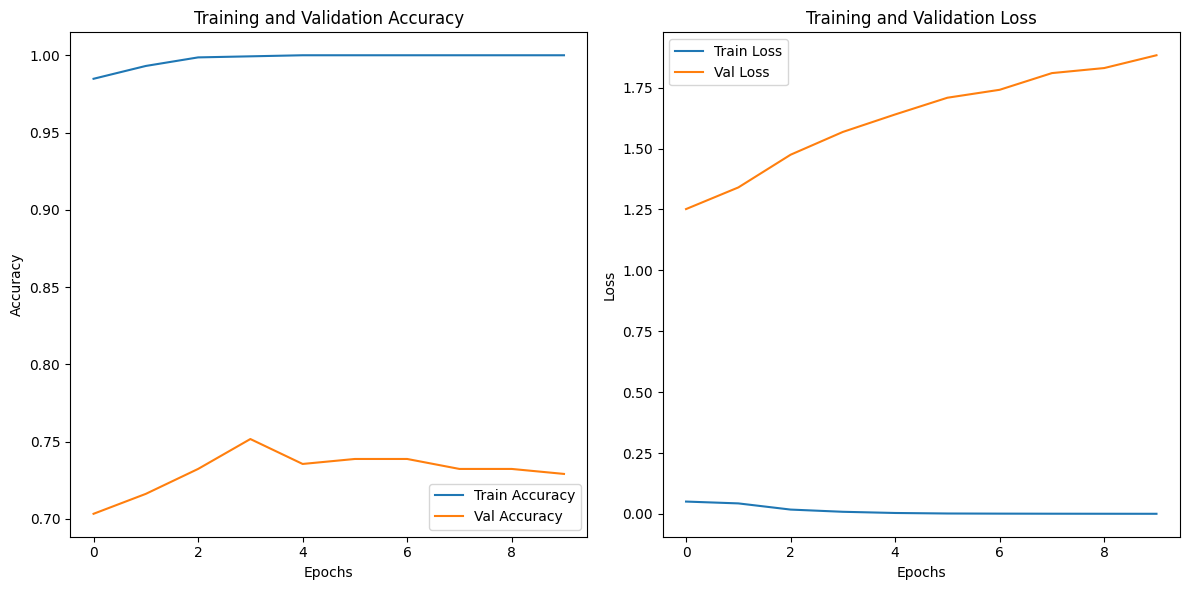

In [ ]:
# Train the model and get the history object
history = model.fit(
    x=X_train, y=y_train,  # Training data
    batch_size=32,         # Batch size
    epochs=10,             # Number of epochs
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[tensorboard, checkpoint]  # Callbacks
)

# Now call the plot_metrics function
plot_metrics(history)
